In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
sys.path.append('/Users/ssulheim/git/mwf_gems/code/python')
import leakage_reframed
import ng_utils
import leakage
import reframed
import cobra
import scipy

/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_99306/1017752051.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Yeast

In [2]:
exometabolites_folder = Path("../../data/yeast/")
organism = 'yeast'
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

In [3]:
gDW_per_OD = np.mean([0.644, 0.848])

In [4]:
concentrations, concentrations_std = leakage.get_concentrations(exometabolites_folder, 'yeast')

In [5]:
df_OD = pd.read_csv(fn_OD, index_col=0)
df_OD.fillna(df_OD['OD std'].mean())


,OD mean,OD std
Time,,
0,0.790,0.174697
1,0.807,0.174697
2,1.170,0.098995
3,1.950,0.084853
4,3.000,0.127279
5,4.675,0.077782
6,6.805,0.049497
7,7.010,0.197990
8,6.750,0.608112


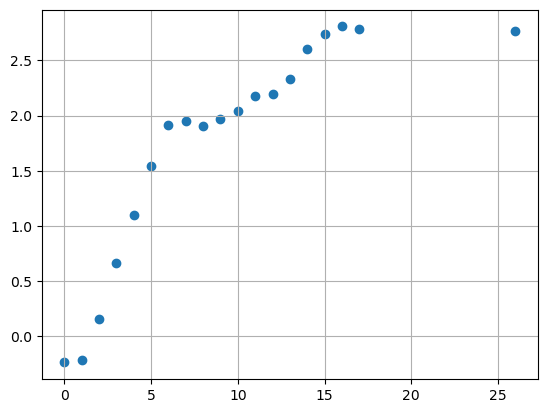

In [6]:
plt.scatter(df_OD.index, np.log(df_OD['OD mean']))
plt.grid()

# Estimate max glucose uptake rate
Answer = 8.4 mmol/gDW/h

In [7]:
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

df_glucose = pd.read_csv(fn_glucose, index_col=0)
df_glucose.loc[0,:]=[20,0] # From paper (in g/L)

In [8]:
cum_OD = np.zeros(19)*np.nan
for i in range(16):
    cum_OD[i+1] = scipy.integrate.simpson(df_OD.loc[1:i+1, 'OD mean'])

In [9]:
df_OD['Cum OD'] = cum_OD
df_OD['Cum OD gDW'] = df_OD['Cum OD']*gDW_per_OD
df_glucose['Glucose mM'] = df_glucose['Glucose mean']/180.18*1000

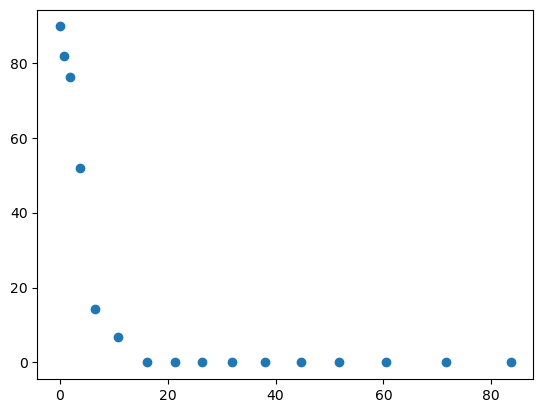

In [10]:
plt.scatter(df_OD['Cum OD gDW'], df_glucose['Glucose mM'])

In [11]:
df_OD.loc[1:6, 'Cum OD gDW']

Time
1     0.000000
2     0.737421
3     1.849334
4     3.678899
5     6.480751
6    10.734505
Name: Cum OD gDW, dtype: float64

In [12]:
np.polyfit(df_OD.loc[1:6, 'Cum OD gDW'], df_glucose.loc[1:6, 'Glucose mM'], 1)

array([-8.41111574, 86.33002799])

## Mapping

In [13]:
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Yeast metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()


# Estimate rates

## Simpson integration

In [14]:
xt = np.zeros(len(df_OD)-1)
for i in range(1, len(df_OD)-1):
    xt[i] = scipy.integrate.simpson(df_OD.loc[:i, 'OD mean'].values, x = df_OD.index[:i+1])
    # xt[i] = np.trapz(df_OD.loc[:i, 'OD mean'], dx=1)
    print(i, df_OD.loc[i, 'OD mean'], xt[i]*gDW_per_OD)

1 0.807 0.595681
2 1.17 1.2900826666666667
3 1.95 2.4279191666666664
4 3.0 4.266622666666667
5 4.675 7.0905435
6 6.805 11.354866
7 7.01 16.627531833333332
8 6.75 21.698155999999997
9 7.15 26.841826
10 7.74 32.41320266666666
11 8.86 38.572054333333334
12 9.025 45.394845999999994
13 10.265 52.52318683333333
14 13.53 61.21377599999999
15 15.47 72.11314683333332
16 16.57 84.086136
17 16.23 96.410056


In [15]:
x = pd.Series(xt*gDW_per_OD, index = df_OD.index[:-1])
x

Time
0      0.000000
1      0.595681
2      1.290083
3      2.427919
4      4.266623
5      7.090543
6     11.354866
7     16.627532
8     21.698156
9     26.841826
10    32.413203
11    38.572054
12    45.394846
13    52.523187
14    61.213776
15    72.113147
16    84.086136
17    96.410056
dtype: float64

Text(0, 0.5, 'Cumulative gDW')

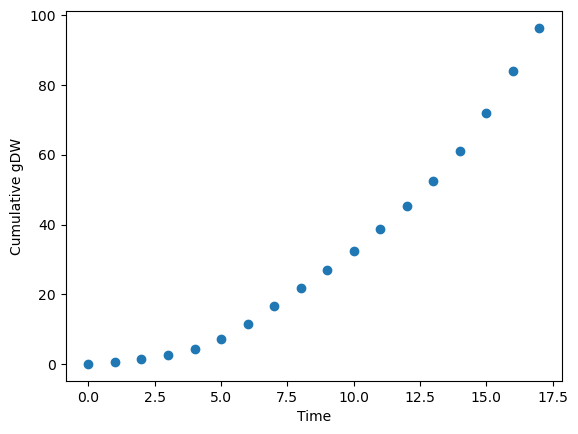

In [16]:
plt.scatter(df_OD.index[:-1], x)
plt.xlabel('Time')
plt.ylabel('Cumulative gDW')

# Fit with custom limits

In [17]:
specific_limits = {
'G6P': (4,6),
'F6P': (1,6),
'FBP': (1,6),
'DHAP': (1,6),
'23PG': (4,6),
'PEP': (1,6),
'RU5P+X5P': (1,6),
'CIT': (3,6),
'ACN': (4,6),
'ICIT': (1,6),
'SUC': (1,5),
'ASN': (1,6),
'GLU': (1,6),
'SER': (1,6),
'ASP': (1,6),
'GLN': (1,4),
'TYR': (1,6),
'PRO': (1,5),
'ALA': (1,6),
'MET': (1,6),
'VAL': (1,5),
'PHE': (1,5),
'LEU+ILEU': (1,6),
'HIS': (1,6),
'LYS': (1,4),
'ARG': (1,6),
'PYR': (1,6),
'ORO': (1,6),
'FUM': (2,6),
'URA': (1,6),
'AKG': (1,6),
'SHI': (1,6),
'ACT': (1,6),
'ETH': (1,6)}

R-squared: 0.847667
R-squared: 0.960235
R-squared: 0.686071
R-squared: 0.963961
23PG One or zero non-zero values in expo. phase
PEP One or zero non-zero values in expo. phase
RU5P+X5P One or zero non-zero values in expo. phase
R-squared: 0.966436
ACN One or zero non-zero values in expo. phase
ICIT One or zero non-zero values in expo. phase
R-squared: 0.937218
R-squared: 0.842417
R-squared: 0.365221
R-squared: 0.660752
R-squared: 0.715731
R-squared: 0.754510
R-squared: 0.539560
R-squared: 0.985212
R-squared: 0.217694
R-squared: 0.289633
R-squared: 0.743323
R-squared: 0.630561
R-squared: 0.049592
HIS More than 1 zero
R-squared: 0.449998
R-squared: 0.608571
ARG More than 1 zero
R-squared: 0.050509
R-squared: 0.924146
R-squared: 0.796698
FUM More than 1 zero
R-squared: 0.956350
R-squared: 0.037587
R-squared: 0.629342
SHI One or zero non-zero values in expo. phase
R-squared: 0.953008
R-squared: 0.992810


/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_99306/4200547228.py:60: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, y_max)


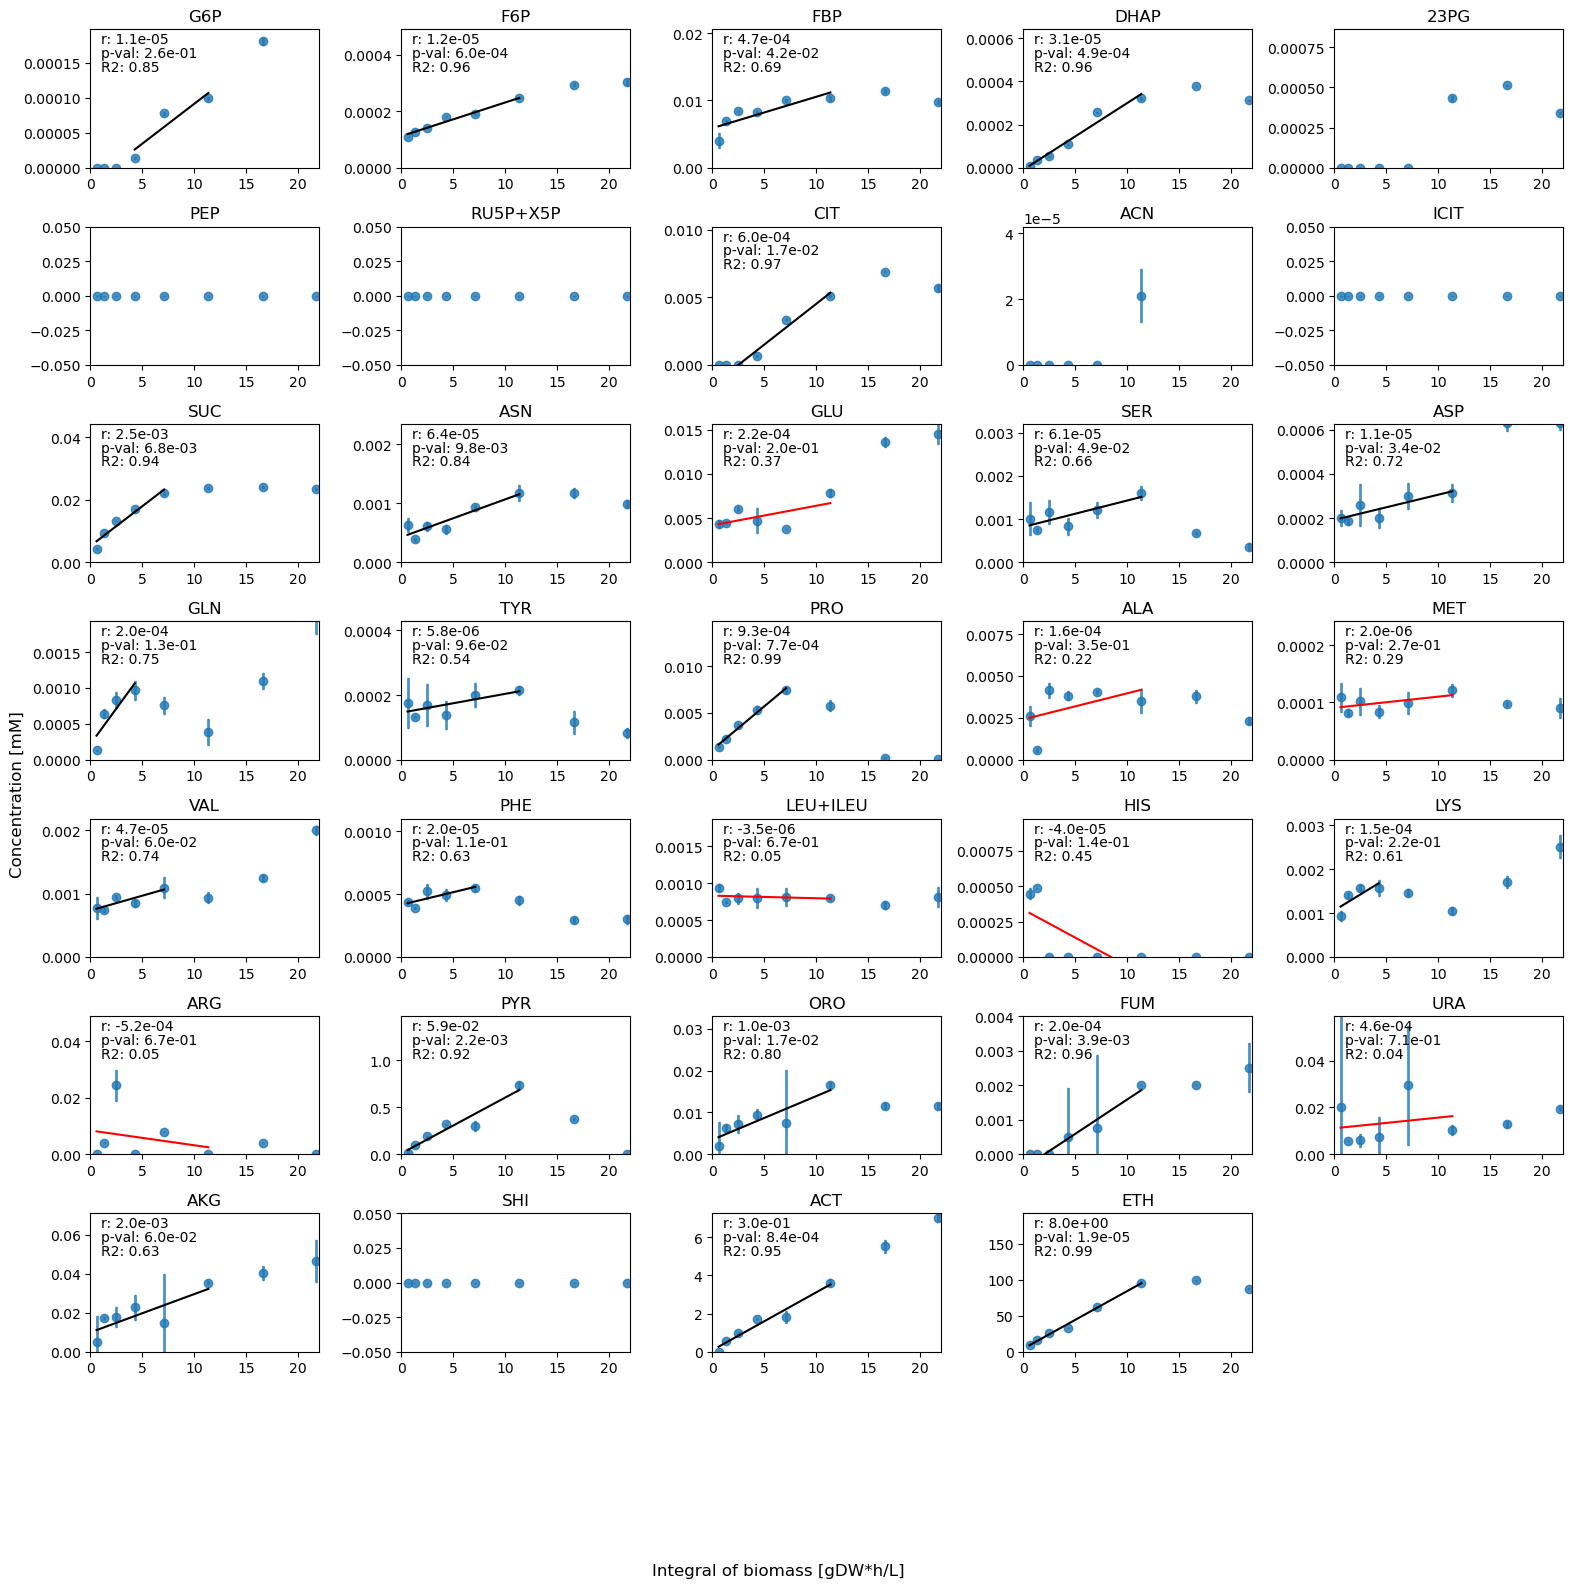

In [18]:
rate_dict_m = {}
fig, axes = plt.subplots(8,5, figsize = (16, 16), sharex = False)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
data_list = []
for i,c in enumerate(concentrations.columns):
    # print(c)
    plot_fit = True
    conc = concentrations[c][:-1]*1e-3 # Convert from uM to mM #
    conc_std = concentrations_std[c][:-1]*1e-3
    lim = specific_limits[c]
    idx = ((concentrations.index >= lim[0]) & (concentrations.index <= lim[1]))[:-1]
    rate_conc = conc[idx]
    if np.sum(rate_conc == 0) > 1:
        if np.sum(rate_conc == 0) >= len(rate_conc)-1:
            print(c, 'One or zero non-zero values in expo. phase')
            plot_fit = False
        else:
            print(c, 'More than 1 zero')
    # conc[conc==0] = np.nan
    # fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[idx],
    #                                            conc[idx], full_output=True)

    # rate = fit[0]
    # std_err = np.sqrt(np.diag(cov))[0]
    # t_score = fit[0]/std_err
    # n_df = np.sum(idx)-2
 
    # p_val = scipy.stats.t.sf(t_score, df = n_df)*2 # *2 is to get two-sided
    if plot_fit:
        res = scipy.stats.linregress(x[idx], conc[idx])
        print(f"R-squared: {res.rvalue**2:.6f}")
        r2 = res.rvalue**2
        data = [res.slope, res.stderr,res.pvalue, c, res.pvalue < 0.05, r2]
        data_list.append(data)
        x_fit = np.linspace(x[idx].min(), x[idx].max(), 3)
        y_fit = fun(x_fit, res.slope, res.intercept)
    # rate_dict_m[c] = fit[0]
    # print(fit)
    
    ax = axes[i]
    ax.errorbar(x, conc, yerr = conc_std, fmt='o',color='C0',capthick=1,elinewidth=2,capsize=1, zorder = 0, alpha= 0.8)

    # ax.scatter(x, conc)
    # ax.scatter(x, conc)
    y_max = np.max(conc[idx])*2#[idx]

    if plot_fit:
        if r2 > 0.5:
            ax.plot(x_fit, y_fit, 'k')
        else:
            ax.plot(x_fit, y_fit, 'r')
            
        ax.annotate(f'r: {res.slope:.1e}', (1, y_max*0.9))
        ax.annotate(f'p-val: {res.pvalue:.1e}', (1, y_max*0.8))
        ax.annotate(f'R2: {r2:.2f}', (1, y_max*0.7))
        
    ax.set_title(c)
    ax.set_xlim(0, 22)
    ax.set_ylim(0, y_max)

    i +=1
    # print(i)

while i<(8*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Integral of biomass [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.savefig('yeast_fitted_rates_manual_limits.png', dpi = 400)
plt.show()

In [19]:
rate_data = pd.DataFrame(data_list, columns = ['Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'p-val', 'Metabolite abbrv.', 'Significance', 'R2'])

In [20]:
# rate_dict = {}
# fig, axes = plt.subplots(8,5, figsize = (8, 12), sharex = True)
# axes = axes.flatten()
# fun = lambda x, a ,b: x*a+b
# for i,c in enumerate(concentrations.columns):
#     conc = concentrations[c]*1e-3
#     conc[conc==0] = np.nan
#     nan_idx = ~np.isnan(conc)
#     time_idx = x.index < 7
#     if np.sum(nan_idx&time_idx) == 1:
#         conc[0] = 0
#         nan_idx[0] = True
#     # print(c)
#     # print(conc[nan_idx&time_idx])
#     rate_conc = conc[nan_idx&time_idx]
#     selection = np.ones(len(conc)).astype(bool)
#     if (5 in rate_conc.index) and (6 in rate_conc.index):
#         if rate_conc[6] < rate_conc[5]:
#             selection[6] = False
#             if rate_conc[5] < rate_conc[4]:
#                 selection[5] = False
                
#     if len(conc[nan_idx&time_idx]) >1:
#         fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[nan_idx&time_idx&selection],
#                                                    conc[nan_idx&time_idx&selection],
#                                                    full_output=True)
#         rate_dict[c] = fit[0]
#     else:
#         rate_dict[c] = np.nan

#     # print(fit)
#     x_fit = np.linspace(0, x[nan_idx&time_idx].max(), 3)
#     y_fit = fun(x_fit, *fit)
#     ax = axes[i]
#     # ax.scatter(x, conc)
#     ax.scatter(x[nan_idx&time_idx], conc[nan_idx&time_idx])
#     ax.plot(x_fit, y_fit, 'r')
#     ax.set_title(c, )

# i +=1
# # print(i)
# while i<(8*5):
#     axes[i].set_visible(False)
#     i+=1

# fig.supxlabel('Integral of biomass [gDW*h/L]')
# fig.supylabel('Concentration [mM]')

# plt.tight_layout()
# plt.show()


# Get model

## Functions

In [21]:


def print_summary_r(model, solution):
    # Print uptake
    for r_id in model.get_exchange_reactions():
        flux = solution.values[r_id]
        r = model.reactions[r_id]
        if  flux >1e-3:
            print(r_id, r.name, flux, r.lb, r.ub)
        elif flux < -1e-3:
            print(r_id, r.name, flux, r.lb, r.ub)
    #print("## Demands ##")
    #for r in model.demands:
    #    print(r.id, solution[r.id])

    print("Growth: ", solution.values['R_r_2111'])
    print("Prot pool exchange: ", solution.values['R_prot_pool_exchange'])

In [22]:
model_ez = reframed.load_cbmodel('../../models/yeast/ecYeastGEM_batch_8_3_4_no_rev_ex.xml')
model_ez.solver = 'gurobi'
glucose_uptake = -8.4

In [23]:
solution = reframed.FBA(model_ez, constraints={'R_r_1714':(glucose_uptake, 0)})
print_summary_r(model_ez, solution)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-19
R_r_1634 acetate exchange 3.0757547920109873 0.0 inf
R_r_1654 ammonium exchange -2.433034376645051 -inf inf
R_r_1672 carbon dioxide exchange 9.116343047175178 0.0 inf
R_r_1714 D-glucose exchange -8.4 -inf 0.0
R_r_1761 ethanol exchange 4.184084589210849 0.0 inf
R_r_1793 formate exchange 0.015220715199668732 0.0 inf
R_r_1832 H+ exchange -0.33105925084131016 -inf inf
R_r_1992 oxygen exchange -6.284051298123331 -inf 0.0
R_r_2005 phosphate exchange -0.09711569323302217 -inf inf
R_r_2020 potassium exchange -0.0012891476190274053 -inf inf
R_r_2033 pyruvate exchange 4.063716832668949 0.0 inf
R_r_2049 sodium exchange -0.0014098942279721206 -inf inf
R_r_2060 sulphate exchange -0.03251056278015401 -inf inf
R_r_2100 water exchange 15.399401351907864 -inf inf
R_r_2111 growth 0.3551370851315166 0.0 inf
R_prot_pool_exchange prot_pool_exchange 0.103720024310123 0.0 0.103720024310123
Growth:  0.3551370851315166
P

In [24]:
# for mc_id in measured_metabolites:
#     mc_name = model_ez.metabolites[mc_id].name.split(" ")[0]
#     predicted_flux = 0
#     for r_id in model_ez.get_exchange_reactions():
#         flux = solution.values[r_id]
#         r = model_ez.reactions[r_id]
#         if  flux >1e-3:
#             print(r_id, r.name, flux, r.lb, r.ub)
#             me_id = r.get_substrates()
#             if len(me_id):
#                 me_name = model_ez.metabolites[me_id[0]].name.split(' ')[0]
#                 if me_name == mc_name:
#                     predicted_flux = flux
#                     break
                

In [25]:
solution2 = reframed.FBA(model_ez, constraints={'R_r_1714':(glucose_uptake, 0), 'R_r_1634': (3.07,4)})
print_summary_r(model_ez, solution2)

R_r_1634 acetate exchange 3.0757547920109385 0.0 inf
R_r_1654 ammonium exchange -2.4330343766450957 -inf inf
R_r_1672 carbon dioxide exchange 9.116343047175292 0.0 inf
R_r_1714 D-glucose exchange -8.4 -inf 0.0
R_r_1761 ethanol exchange 4.1840845892110305 0.0 inf
R_r_1793 formate exchange 0.015220715199668522 0.0 inf
R_r_1832 H+ exchange -0.3310592508414758 -inf inf
R_r_1992 oxygen exchange -6.284051298123256 -inf 0.0
R_r_2005 phosphate exchange -0.0971156932330613 -inf inf
R_r_2020 potassium exchange -0.0012891476190273875 -inf inf
R_r_2033 pyruvate exchange 4.063716832668839 0.0 inf
R_r_2049 sodium exchange -0.0014098942279721013 -inf inf
R_r_2060 sulphate exchange -0.03251056278015357 -inf inf
R_r_2100 water exchange 15.39940135190781 -inf inf
R_r_2111 growth 0.3551370851315117 0.0 inf
R_prot_pool_exchange prot_pool_exchange 0.103720024310123 0.0 0.103720024310123
Growth:  0.3551370851315117
Prot pool exchange:  0.103720024310123


In [26]:
(solution.fobj-solution2.fobj)/0.01

4.884981308350689e-13

# Mapping

In [27]:
met_info_df = pd.read_csv("../../data/met_info_curated.csv", encoding = "ISO-8859-1", index_col = 0)
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)


In [28]:
measured_metabolites = []
for value in met_abrv_to_id.values():
    if not isinstance(value, str):
        continue
    bigg_ids = value.split(', ')
    for bigg_id in bigg_ids:
        m_id = f'M_{bigg_id}__91__c__93__'
        if m_id in model_ez.metabolites:
            measured_metabolites.append(m_id)

# Turnover

In [29]:
solution = reframed.pFBA(model_ez, constraints={'R_r_1714':(glucose_uptake, 0)})
turnover = solution.get_metabolites_turnover(model_ez)

# Shadow prices

In [30]:
if len(measured_metabolites):
    shadow_prices = leakage_reframed.estimate_shadow_prices(model_ez, constraints={'R_r_1714':(glucose_uptake, 0)},
                                                        metabolites = measured_metabolites)

In [31]:
glc_uptake_range = np.linspace(glucose_uptake*1.2, glucose_uptake*0.8, 5, endpoint=True)
shadow_price_list = []
for g in glc_uptake_range:
    shadow_prices_i = leakage_reframed.estimate_shadow_prices(model_ez, constraints={'R_r_1714': (g,0)}, metabolites = measured_metabolites)
    shadow_price_list.append(shadow_prices_i)
shadow_price_list.append(shadow_prices)

In [32]:
df_sp_var = pd.DataFrame(shadow_price_list)

# Make spreadsheet

In [79]:
data = []
drop_mets = ['ru5p__L','xu5p__L'] # The D-forms is used in the pentose phosphate pathway, so we assume that it is primarily the D-forms
# 'Std.Err [mmol/gDW/h]', 'T-score', 'degrees of freedom', 'p-val', 'Metabolite abbrv.', 'Significance']
for _, row in rate_data.iterrows():
    if row['R2']<0.5:
        continue
    abbr = row['Metabolite abbrv.']
    rate = row['Rate [mmol/gDW/h]']
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',') if not x.strip() in drop_mets]
    if len(bigg_ids)>1:
        print(bigg_ids)
    rate_i = rate/len(bigg_ids)
    std_err_i = row['Std.Err [mmol/gDW/h]']/np.sqrt(len(bigg_ids))
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'M_{bigg_id}__91__c__93__'
        mv = -shadow_prices[m_id]
        m = model_ez.metabolites[m_id]
        element_dict = ng_utils.get_element_dict(m)
        Nc = element_dict['C']
        mass = ng_utils.get_mol_weight(m)
        mv_min = -df_sp_var.max()[m_id]
        mv_max = -df_sp_var.min()[m_id]
        
        data.append([abbr, bigg_id, name, mv, mv_min, mv_max, turnover[m_id], Nc, mass, rate_i, std_err_i, row['R2']])
df_rate = pd.DataFrame(data, columns = ['Metabolite abbrv.', 'BiGG ID', 'Metabolite', 
                                        'Metabolite value [gDW/mmol]','MV min', 'MV max', 
                                        'Turnover [mmol/gDW/h]', 'N carbons', 
                                        'Mol weight [g/mol]', 'Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'R2'])

In [80]:
# data = []
# for abbr, rate in rate_dict.items():
#     bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',')]
#     rate = rate/len(bigg_ids)
#     for bigg_id in bigg_ids:
#         name =met_abrv_to_name[abbr]
#         m_id = f'M_{bigg_id}__91__c__93__'
#         mv = -shadow_prices[m_id]
#         m = model_ez.metabolites[m_id]
#         element_dict = ng_utils.get_element_dict(m)
#         Nc = element_dict['C']
#         mass = ng_utils.get_mol_weight(m)
#         model_met_name = m.name.replace('[cytoplasm]','')
#         data.append([bigg_id, name, model_met_name, rate, mv, turnover[m_id], Nc, mass])
# df_rate = pd.DataFrame(data, columns = ['Yeast ID', 'Metabolite', 'Model metabolite name', 'Rate [mmol/gDW/h]', 
#                                         'Metabolite value [gDW/mmol]', 'Turnover [mmol/gDW/h]', 'N carbons', 
#                                         'Mol weight [g/mol]'])

In [81]:
df_rate['Species'] = 'S. cerevisiae'
df_rate['Carbon source'] = 'Glucose'
df_rate['Dataset'] = 'Paczia-13'

In [82]:
df_rate.to_csv('paczia_13_rates_yeast_0824.csv')

# Without enzyme constraints

In [58]:
model0 = model_ez.copy()

In [59]:
model0.reactions.R_prot_pool_exchange

R_prot_pool_exchange:  --> M_prot_pool__91__c__93__ [0.0, 0.103720024310123]

In [60]:
if len(measured_metabolites):
    shadow_prices0 = leakage_reframed.estimate_shadow_prices(model0, constraints={'R_r_1714':(glucose_uptake, 0), 'R_prot_pool_exchange': (0, 1000)},
                                                        metabolites = measured_metabolites)

R_r_1654 ammonium exchange -5.168567390604757 -inf inf
R_r_1672 carbon dioxide exchange 19.476707515807437 0.0 inf
R_r_1714 D-glucose exchange -8.4 -inf 0.0
R_r_1654 ammonium exchange -5.168567390604757 -inf inf
R_r_1672 carbon dioxide exchange 19.476707515807437 0.0 inf
R_r_1714 D-glucose exchange -8.4 -inf 0.0
R_r_1832 H+ exchange -0.21029629245840273 -inf inf
R_r_1992 oxygen exchange -18.015775983615388 -inf 0.0
R_r_2005 phosphate exchange -0.2063307758470199 -inf inf
R_r_2020 potassium exchange -0.002738460146659157 -inf inf
R_r_2049 sodium exchange -0.0029949550364288847 -inf inf
R_r_2060 sulphate exchange -0.06906026835474431 -inf inf
R_r_2100 water exchange 33.07918336899551 -inf inf
R_r_2111 growth 0.7543967346168476 0.0 inf
R_r_4595 Mn(2+) exchange -0.002059503085503994 -inf inf
R_prot_pool_exchange prot_pool_exchange 5.352719933343697 0.0 0.103720024310123
R_r_1654 ammonium exchange -5.168567390604757 -inf inf
R_r_1672 carbon dioxide exchange 19.476707515807437 0.0 inf
R_r_17

In [61]:
data = []
drop_mets = ['ru5p__L','xu5p__L'] # The D-forms is used in the pentose phosphate pathway, so we assume that it is primarily the D-forms
# 'Std.Err [mmol/gDW/h]', 'T-score', 'degrees of freedom', 'p-val', 'Metabolite abbrv.', 'Significance']
for _, row in rate_data.iterrows():
    if row['R2']<0.5:
        continue
    abbr = row['Metabolite abbrv.']
    rate = row['Rate [mmol/gDW/h]']
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',') if not x.strip() in drop_mets]
    if len(bigg_ids)>1:
        print(bigg_ids)
    rate_i = rate/len(bigg_ids)
    std_err_i = row['Std.Err [mmol/gDW/h]']/np.sqrt(len(bigg_ids))
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'M_{bigg_id}__91__c__93__'
        mv = -shadow_prices0[m_id]
        m = model_ez.metabolites[m_id]
        element_dict = ng_utils.get_element_dict(m)
        Nc = element_dict['C']
        mass = ng_utils.get_mol_weight(m)
        
        data.append([abbr, bigg_id, name, mv, Nc, mass, rate_i, std_err_i, row['R2']])
df_rate0 = pd.DataFrame(data, columns = ['Metabolite abbrv.', 'BiGG ID', 'Metabolite', 
                                        'Metabolite value [gDW/mmol]', 'N carbons', 
                                        'Mol weight [g/mol]', 'Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'R2'])

In [63]:
df_rate0.to_csv('paczia_13_rates_yeast_08024_no_enz.csv')